In [11]:
import csv
import glob
import os
import re

In [12]:
from statistics import mean

In [13]:
from Bio.Seq import reverse_complement
from pysam import FastaFile
from maxentpy import maxent_fast
from tqdm import tqdm

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [15]:
long_data1 = list()
long_data2 = list()

In [16]:
MAT5 = maxent_fast.load_matrix(5)
MAT3 = maxent_fast.load_matrix(3)

In [17]:
for path in tqdm(glob.iglob("data/ref/*")):
    if not os.path.isdir(path):
        continue
    
    name = os.path.basename(path)
    
    fa, = list(glob.iglob(f"{path}/fa/*.fa.gz"))
    genome = FastaFile(fa)
    
    scores5 = list()
    scores3 = list()
    
    with open(f"{path}/annot/out/meta_exon.csv", 'r') as f:
        reader = csv.reader(f)
        next(reader)
        
        for row in reader:
            _, gene_func, chrom, *_, strand, _, make_up = row
            
            if gene_func != "protein_coding":
                continue
            
            for exon in make_up.split(","):
                kind, *pos = re.split('[=-]', exon)

                beg, end = map(int, pos)
                beg -= 1
                
                beg5, end5 = [None, None]
                beg3, end3 = [None, None]
                
                if kind == "FE":
                    if strand == "+":
                        beg5, end5 = end - 3, end + 6
                    else:
                        beg5, end5 = beg - 6, beg + 3
                        
                elif kind == "IE":
                    if strand == "+":
                        beg5, end5 = end - 3, end + 6
                        beg3, end3 = beg - 20, beg + 3
                    else:
                        beg5, end5 = beg - 6, beg + 3
                        beg3, end3 = end - 3, end + 20
                        
                elif kind == "LE":
                    if strand == "+":
                        beg3, end3 = beg - 20, beg + 3
                    else:
                        beg3, end3 = end - 3, end + 20
                        
                else:
                    # SE — no 5/3'SS. 
                    continue
                
                if beg5 and end5 and beg5 > 0:
                    seq = genome.fetch(chrom, beg5, end5)
                    if strand == "-":
                        seq = reverse_complement(seq)
                        
                    if not set(seq).issubset("ACGT") or len(seq) != 9:
                        continue
                        
                    score = maxent_fast.score5(seq, matrix=MAT5)
                    scores5.append(score)
                    
                if beg3 and end3 and beg3 > 0:
                    seq = genome.fetch(chrom, beg3, end3)
                    if strand == "-":
                        seq = reverse_complement(seq)
                    
                    if not set(seq).issubset("ACGT") or len(seq) != 23:
                        continue
                    
                    score = maxent_fast.score3(seq, matrix=MAT3)
                    scores3.append(score)
                    
    mean_score5 = mean(scores5)
    mean_score3 = mean(scores3)
    
    for p, score in zip("53", [mean_score5, mean_score3]):
        long_data1.append({
            'name': name,
            'score': score,
            'p': p
        })
        
    for p, scores in zip("53", [scores5, scores3]):
        long_data2.append({
            'name': name,
            'percent_positive': len([x for x in scores if x > 0]) / len(scores5) * 100,
            'p': p
        })

64it [07:16,  6.82s/it]


In [18]:
frame1 = pd.DataFrame(long_data1)
frame2 = pd.DataFrame(long_data2)

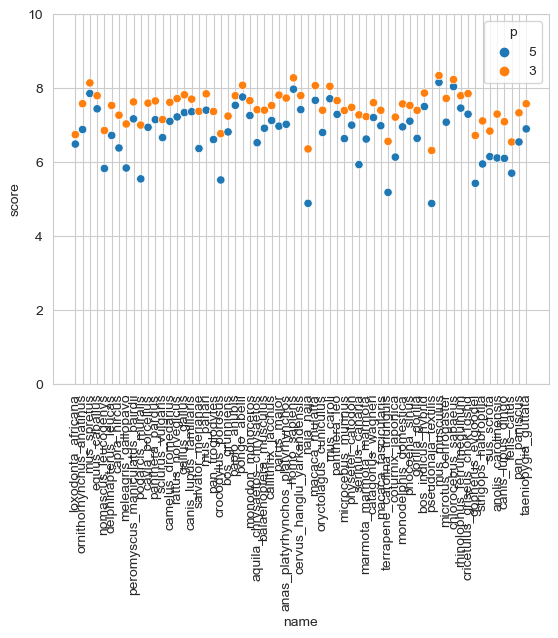

In [19]:
sns.scatterplot(frame1, x='name', y='score', hue='p')

_ = plt.xticks(rotation=90)
_ = plt.ylim(0, 10)

plt.savefig("figs/main1b_2.pdf")

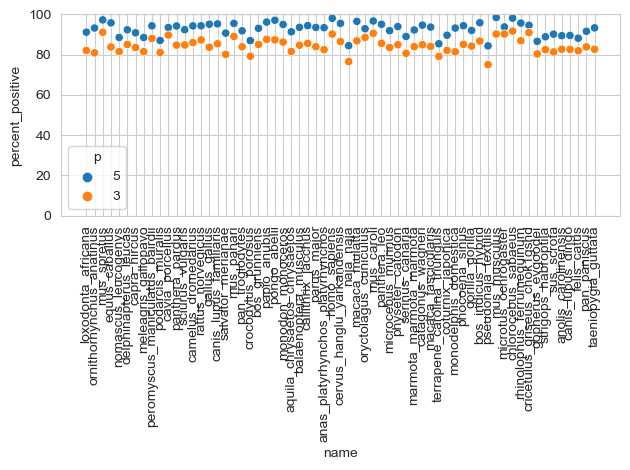

In [20]:
sns.scatterplot(frame2, x='name', y='percent_positive', hue='p')

_ = plt.xticks(rotation=90)
_ = plt.ylim(0, 100)

plt.tight_layout()
plt.savefig("figs/main1b_1.pdf")